# Generating Data
Like in my post on [building neural networks from scratch](https://beckernick.github.io/neural-network-scratch/), I'm going to use simulated data. I can easily simulate separable data by sampling from a multivariate normal distribution.

In [4]:
import numpy as np
import nodepy 
import matplotlib.pyplot as plt
import sys
import scipy as sp
from scipy import io
%matplotlib inline

np.random.seed(12)
num_observations = 3
clusters = 1
dim = 10
spread = 10
margin = np.random.randint(10, size=dim) * 50

for i in range(clusters):
    if i == 0:
        x1 = np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations)
        x2 = np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations)
    else:
        x1 = np.append(x1, np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations), axis=0)
        x2 = np.append(x2, np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations), axis=0)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(len(x1)),
                              np.ones(len(x2))))
intercept = np.ones((simulated_separableish_features.shape[0], 2))
simulated_separableish_features = np.hstack((intercept, simulated_separableish_features))
dim += 2

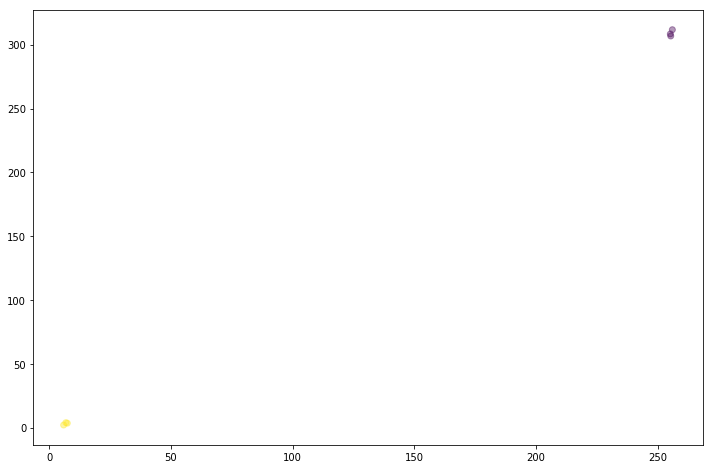

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, -1], simulated_separableish_features[:, 2],
            c = simulated_labels, alpha = .4)

# Quadratic

In [6]:

def grad_logistic(X, Y, w):
    pred = np.dot(X, w) - Y
    return np.dot(X.T, pred) + 4* np.dot(w[-1].T, w[-1]) * np.hstack([[0]*(dim-1),w[-1]])

def loss_logistic(X, Y, w):
    pred = Y - np.dot(X, w)
    return np.dot(pred.T, pred) + np.dot(w[-1].T, w[-1])**2


## Show that GD works

In [4]:
def gd(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in xrange(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print losses[int(step/period)]
        
    return weights, losses

In [5]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = gd(f, df, num_steps = int(1e6), learning_rate = 1e-6, 
                     inits=weights, period=500)

2.996290005
0.00426339959744
0.00173069191139
0.000726516873182
0.000306737242127


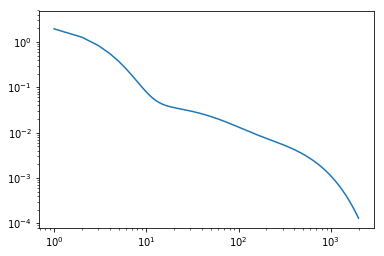

In [6]:
plt.loglog(losses[:])

In [7]:
print(losses[-1])

0.000130557066578


In [7]:
def rgd4(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in xrange(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient/(np.linalg.norm(gradient)^{3/2})
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print losses[int(step/period)]
        
    return weights, losses

SyntaxError: invalid syntax (<ipython-input-7-59cf23a778b2>, line 13)

In [8]:
def nag(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    x = inits
    x_prev = inits
    y = inits
    for k in xrange(num_steps):
        # Update weights with log likelihood gradient
        x, x_prev = y - learning_rate * df(y), x
        y = x + (k-1.0)/(k+2.0)*(x-x_prev)

        # Print log-likelihood every so often
        if k % period == 0:
            losses[int(k/period)] = f(x)
        if k % (num_steps/10) == 0:
            print losses[int(k/period)]
        
    return x, losses

SyntaxError: invalid syntax (<ipython-input-8-5edfda6c148f>, line 15)

In [9]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = nag(f, df, num_steps = int(1e6), learning_rate = 1e-6, 
                     inits=weights, period=500)

2.996290005
1.38626699619e-08
6.76037577688e-10
8.0899051656e-11
4.06784246467e-12
1.57940380124e-12
5.11492031801e-12
4.71804759185e-12
2.45015735692e-12
6.84502471145e-13


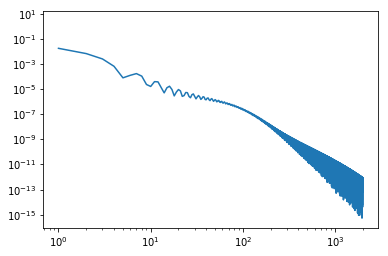

In [10]:
plt.loglog(losses[:])

# Simulate ODE flow

In [12]:

import nodepy.runge_kutta_method as rk
import nodepy.convergence as cv
from nodepy import ivp

class ODE_IVP(nodepy.ivp.IVP):
    
    def __init__(self, X, Y, p, u0, t0=0., T=1000000., desc='', name=''):
        
        #intercept = np.ones((X.shape[0], 1))
        #self.X = np.hstack((intercept, X))
        self.Y = Y
        self.X = X
        self.p = float(p)
        self.u0  = u0
        self.dim = len(u0)/2
        self.rhs = self.dynamics
        self.T   = T
        self.exact = None
        self.description = desc
        self.t0 = t0
        self.name = name
    
    def dynamics(self, t, u):
        x = u[:self.dim]
        v = u[self.dim:]
        p = self.p
        dv = - (p+1) / (t) * v - p**2 * t**(p-2) * grad_logistic(self.X, self.Y, x)
        return np.append(v, dv)
    
    

In [13]:
# Same integrator on different ODE

def simulate(p, s, N, period, step, inits):
    h = step
    if s==1:
        name = 'FE'
    elif s==2:
        name = 'SSP22'
    elif s==4:
        name = 'RK44'
    elif s==8:
        name = 'PD8'
    else:
        return None
    u = [inits]
    integrator =rk.loadRKM(name)
    loop = N/period
    losses = np.zeros(int(N/period))
    ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    for j in range(loop):
        losses[j] = loss_logistic(simulated_separableish_features, simulated_labels, u[-1][:dim])
        t,u = integrator(ode_ivp, t0= 0.1 + j * period * h, dt=h, max_steps=period)
        ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    return losses



In [14]:
N = int(1e4)
truncate = 0
period = 500
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period)) - period + 1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/matplotlib/ticker.py:2041: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


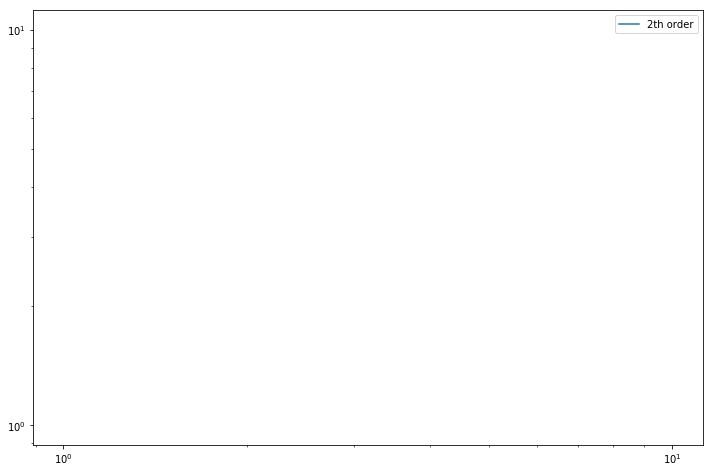

In [12]:
plt.figure(figsize = (12, 8))
losses = simulate(2, 8, N, period, 1e-2, np.zeros(dim * 2))
plt.loglog(nrange, losses[truncate:], label=str(2) + 'th order')
plt.legend()

2.996290005
3.6871400954e-06
1.90475854593e-06
1.86854255901e-06
1.83449406397e-06
2.996290005
3.60781312976e-14
1.06248687312e-14
3.27922370106e-16
3.19990141623e-19
1.64917222249e-18
3.42816518866e-19
1.06162618868e-20
2.97335324638e-21
1.74384380306e-21


(1e-20, 100)

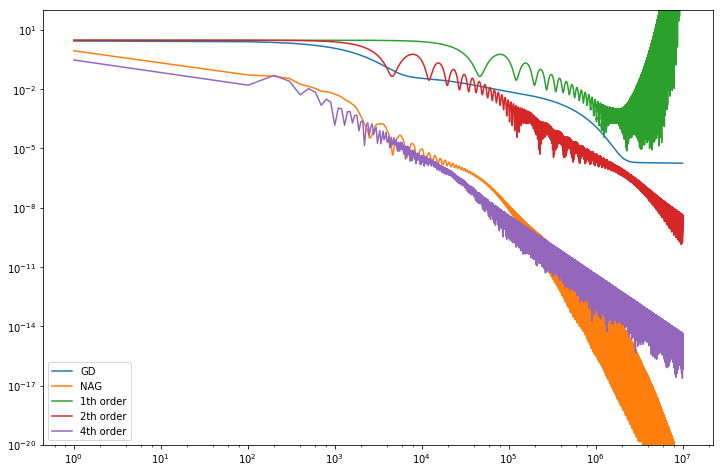

In [19]:
N = int(1e7)
truncate = 0
period = 100
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [1,2,4]
steps = [1e-6, 1e-5, 1e-3]
plt.figure(figsize = (12, 8))
loss_matrix = np.zeros((len(svals)+2, len(nrange)))


weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

_, gdlosses = gd(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
loss_matrix[0] = gdlosses

weights = np.zeros(dim)
plt.loglog(nrange, gdlosses[truncate:], label='GD')
_, naglosses = nag(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
loss_matrix[1] = naglosses

plt.loglog(nrange, naglosses[truncate:], label='NAG')

losslst = []
for i, s in enumerate(svals):
    losses = simulate(2, s, N, period, steps[i], np.zeros(dim * 2))
    losslst.append(losses)
    loss_matrix[i+2, :] = losses
    plt.loglog(nrange, losses[truncate:], label=str(s) + 'th order')
plt.legend()
plt.ylim(1e-20, 100)

In [20]:
sp.io.savemat('quad-4th.mat', {'loss_matrix': loss_matrix})

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in multiply


(1e-10, 100)

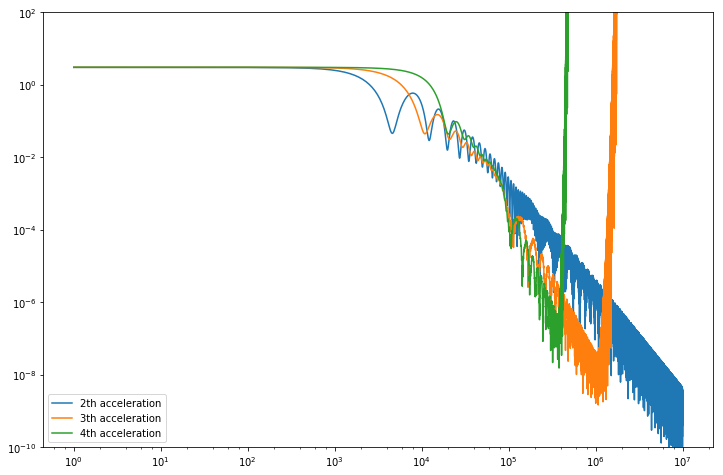

In [141]:
# Different choice of p
N = int(1e7)
truncate = 0
period = 100
pvalues = [2, 3, 4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [2, 2, 2]
steps = [1e-5, 1e-5, 1e-5]
plt.figure(figsize = (12, 8))


weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

losslst = []
for i, s in enumerate(svals):
    losses = simulate(pvalues[i], s, N, period, steps[i], np.zeros(dim * 2))
    losslst.append(losses)
    plt.loglog(nrange, losses[truncate:], label=str(pvalues[i]) + 'th acceleration')
plt.legend()
plt.ylim(1e-10, 100)